# <a id='toc1_'></a>[Import final_input.csv](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Import final_input.csv](#toc1_)    
- [Risk score card model](#toc2_)    
  - [WOE](#toc2_1_)    
- [Xếp hạng các biến theo sức mạnh dự báo](#toc3_)    
- [Hồi quy logistic](#toc4_)    
- [Trả ra prob of risk cho data](#toc5_)    
  - [Lưu model logistic](#toc5_1_)    
- [Tính điểm score cho mỗi feature](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [15]:
import os
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import sklearn
from datetime import datetime
from sqlalchemy import create_engine
import pyodbc

In [16]:

def sql_native_connection(db_name='DRAFT'):
    """
    :param db_name: Tên database muốn đăng nhập
    :return: kết nối vào database
    """
    try:
        cnxn_str = ("Driver={SQL Server Native Client 11.0};""Server=PS1BICCAPP04;" +
                    "Database={};".format(db_name) +
                    "Trusted_Connection=yes;")
        engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(cnxn_str))
        print(f'Connected to server {db_name}')
        return engine.connect()
    except Exception as E:
        print(E)



def msssql_connect(dbname='draft'):
    server = 'PS1BICCAPP04'
    database = dbname
    driver = 'SQL Server'
    conn_str = 'DRIVER=' + driver + ';SERVER=' + server + ';DATABASE=' + database + ';Trusted_Connection=yes'
    conn = pyodbc.connect(conn_str)
    return conn


conn = msssql_connect('draft')

connection = sql_native_connection()


wd = os.getcwd()

Connected to server DRAFT


In [17]:
data_raw = pd.read_sql_query("select  * from draft.dbo.ngamt_stmt_upite_20240511", conn)

In [ ]:
file_path = wd + '\\01. data\\input\\final_input.csv'
data_raw.to_csv(file_path, index=False)
 

# <a id='toc2_'></a>[Risk score card model](#toc0_)

In [ ]:
file_path = wd+'\\01. data\\input\\final_input.csv'
data_raw = pd.read_csv(file_path)

data = data_raw
data['nhom_no_cic'] = data['nhom_no_cic'].astype('str')
# data['nhom_no_cic'] = data['nhom_no_cic'].astype('object')
columns_to_keep = data.columns.drop(['cif', 'acnt_contract_oid', 'contract_number', 'issue_month', 'issue_date_ctr', 'unlock_date'])
data = data[columns_to_keep]
import math
columns_to_keep

Index(['product_group', 'contract_limit', 'bi_card_type', 'liab_limit',
       'campaign_group', 'cus_income', 'income_tier', 'gender',
       'marital_status', 'edu_level', 'province_city', 'age', 'cus_class',
       'ovd_days', 'ovd_days_6m', 'ovd_days_12m', 'ovd_days_24m',
       'ovd_days_36m', 'nhom_no_cic', 'revolver_group', 'nii_24m', 'nfi_24m',
       'toi_24m', 'provision_24m', 'bad_flag'],
      dtype='object')

In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'data'
total_samples = len(data)
split_ratio = 0.2

# Randomly shuffle the data
shuffled_data = data.sample(frac=1, random_state=123)

# Calculate the split index
split_index = int(split_ratio * total_samples)

# Split the data into two parts
data_test = shuffled_data[:split_index]
data_train = shuffled_data[split_index:]

data_test.to_csv(wd+'\\01. data\\input\\data_test.csv', index = False)
data_train.to_csv(wd+'\\01. data\\input\\data_train.csv', index = False)


wd = os.getcwd()
data_train = pd.read_csv(wd+'\\01. data\\input\\data_train.csv')
data_train['nhom_no_cic'] = data_train['nhom_no_cic'].astype('str')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Biểu đồ histogram
def _plot_hist_subplot(x, fieldname, bins = 10, use_kde = True):
  x = x.dropna()
  xlabel = '{} bins tickers'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'histogram plot of {} with {} bins'.format(fieldname, bins)
  ax = sns.distplot(x, bins = bins, kde = use_kde)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  return ax

# Biểu đồ barchart
def _plot_barchart_subplot(x, fieldname):
  xlabel = 'Group of {}'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'Barchart plot of {}'.format(fieldname)
  x = x.fillna('Missing')
  df_summary = x.value_counts(dropna = False)
  y_values = df_summary.values
  x_index = df_summary.index
  ax = sns.barplot(x = x_index, y = y_values, order = x_index)
  # Tạo vòng for lấy tọa độ đỉnh trên cùng của biểu đồ và thêm label thông qua annotate.
  labels = list(set(x))
  for label, p in zip(y_values, ax.patches):
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.15))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  return ax


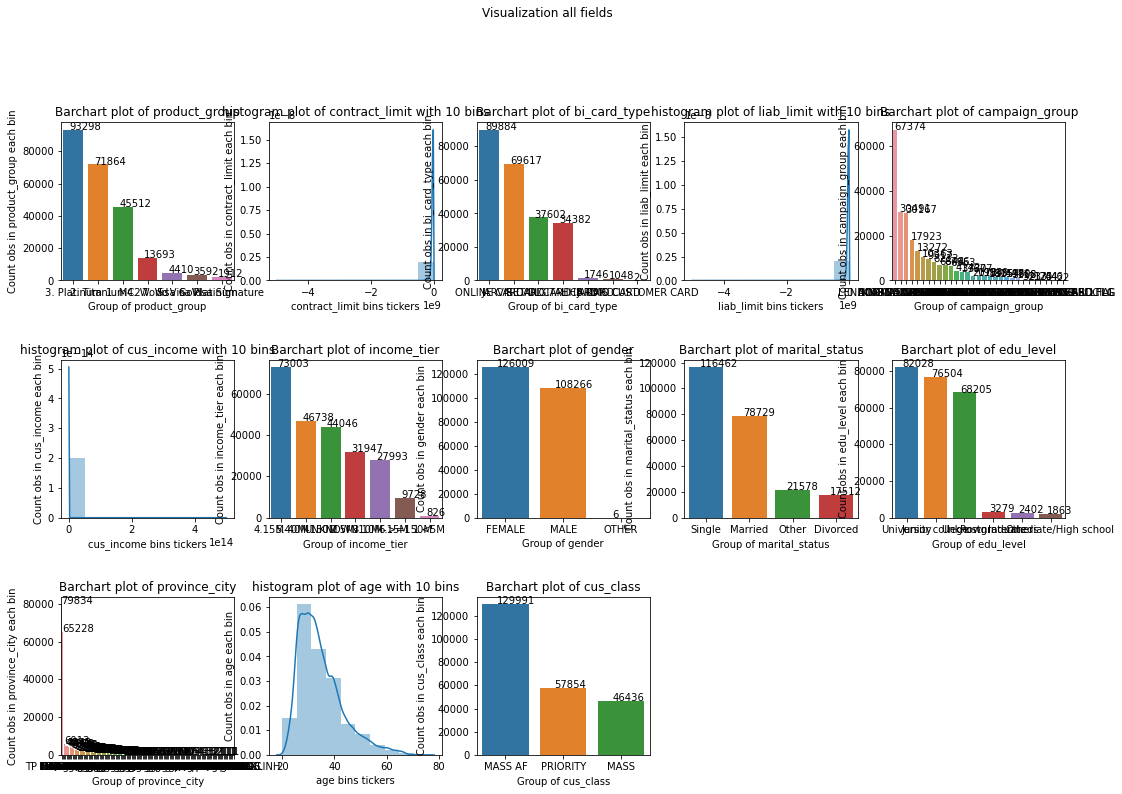

In [ ]:
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
# Tạo vòng for check định dạng của biến và visualize
for i, (fieldname, dtype) in enumerate(zip(data.columns, data.dtypes.values)):
  if i <= 12:
    ax_i = fig.add_subplot(4, 5, i+1)
    if dtype in ['float64', 'int64']:
      ax_i = _plot_hist_subplot(data[fieldname], fieldname=fieldname)
    else:
      ax_i = _plot_barchart_subplot(data[fieldname], fieldname=fieldname)
      
fig.suptitle('Visualization all fields')
plt.show()

## <a id='toc2_1_'></a>[WOE](#toc0_)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

MAX_VAL = 999999999999999
MIN_VAL = -MAX_VAL

def _bin_table(data, colname, n_bins = 10, qcut = None):
  X = data[[colname, 'bad_flag']]
  X = X.sort_values(colname)
  coltype = X[colname].dtype

  if coltype in ['float64', 'int64']:
    if qcut is None:
      try:
        bins, thres = pd.qcut(X[colname], q = n_bins, retbins=True)
        # Thay thế threshold đầu và cuối của thres
        thres[0] = MIN_VAL
        thres[-1] = MAX_VAL
        bins, thres = pd.cut(X[colname], bins=thres, retbins=True)
        X['bins'] = bins
      except:
        print('n_bins must be lower to bin interval is valid!')
    else:
      bins, thres = pd.cut(X[colname], bins=qcut, retbins=True)
      X['bins'] = bins
  elif coltype == 'object':
    X['bins'] = X[colname]

  df_GB = pd.pivot_table(X, 
                index = ['bins'],
                values = ['bad_flag'],
                columns = ['bad_flag'],
                aggfunc = {
                    'bad_flag':np.size
                })

  df_Count = pd.pivot_table(X, 
                index = ['bins'],
                values = ['bad_flag'],
                aggfunc = {
                    'bad_flag': np.size
                })
  
  if coltype in ['float64', 'int64']:
    df_Thres = pd.DataFrame({'Thres':thres[1:]}, index=df_GB.index)
  elif coltype == 'object':
    df_Thres = pd.DataFrame(index=df_GB.index)
    thres = None
  df_Count.columns = ['no_obs']
  df_GB.columns = ['#bad', '#good']
  df_summary = df_Thres.join(df_Count).join(df_GB)
  return df_summary, thres  

In [ ]:
def _woe(data, colname, n_bins = None, min_obs = 100, qcut = None):
  # Thống kê bins và lấy ra thres hold ban đầu
  df_summary, thres = _bin_table(data, colname, n_bins = n_bins, qcut = qcut)
  # Thay thế giá trị 0 của #BAD trong df_summary bằng 1 để không bị lỗi chia cho 0
  df_summary['#bad'] = df_summary['#bad'].replace({0:1})
  
  if qcut is not None:
    # Lọc bỏ threshold để tạo thành threshold mới mà thỏa mãn số lượng quan sát >= min_obs
    exclude_ind = np.where(df_summary['no_obs'] <= min_obs)[0]
    if exclude_ind.shape[0] > 0:
      new_thres = np.delete(thres, exclude_ind)
      print('Auto combine {} bins into {} bins'.format(n_bins, new_thres.shape[0]-1))
      # Tính toán lại bảng summary
      df_summary, thres = _bin_table(data, colname, qcut=new_thres)
  
  new_thres = thres
  df_summary['good/bad'] = df_summary['#good']/df_summary['#bad']
  df_summary['%bad'] = df_summary['#bad']/df_summary['#bad'].sum()
  df_summary['%good'] = df_summary['#good']/df_summary['#good'].sum()
  df_summary['woe'] = np.log(df_summary['%good']/df_summary['%bad'])
  df_summary['iv'] = (df_summary['%good']-df_summary['%bad'])*df_summary['woe']
  df_summary['column'] = colname
  iv = df_summary['iv'].sum()
  print('information value of {} column: {}'.format(colname, iv))
  return df_summary, iv, new_thres



In [ ]:
def _plot(df_summary):
  colname = list(df_summary['column'].unique())[0]
  df_summary['woe'].plot(linestyle='-', marker='o')
  plt.title('woe of {} field'.format(colname))
  plt.axhline(y=0, color = 'red')
  plt.xticks(rotation=45)
  plt.ylabel('woe')
  plt.xlabel('bin group')

In [ ]:
# nbins = {'contract_limit': 5, 'liab_limit': 5, 'cus_income': 4, 'age':7}

df_summary, iv, thres = _woe(data, 'age', n_bins = 7, min_obs= 100)
df_summary

information value of age column: 0.035410705142111934


,Thres,no_obs,#bad,#good,good/bad,%bad,%good,woe,iv,column
bins,,,,,,,,,,
"(-999999999999999.0, 27.0]",2.700000e+01,46577,44157,2420,0.054804,0.201472,0.160169,-0.229418,0.009476,age
"(27.0, 29.0]",2.900000e+01,26727,25231,1496,0.059292,0.115120,0.099014,-0.150712,0.002427,age
"(29.0, 32.0]",3.200000e+01,40189,37849,2340,0.061825,0.172691,0.154875,-0.108887,0.001940,age
"(32.0, 34.0]",3.400000e+01,23795,22305,1490,0.066801,0.101769,0.098617,-0.031469,0.000099,age
"(34.0, 38.0]",3.800000e+01,34480,32182,2298,0.071406,0.146834,0.152095,0.035198,0.000185,age
"(38.0, 43.0]",4.300000e+01,30134,27936,2198,0.078680,0.127462,0.145476,0.132198,0.002382,age
"(43.0, 999999999999999.0]",1.000000e+15,32379,29512,2867,0.097147,0.134652,0.189754,0.343035,0.018902,age


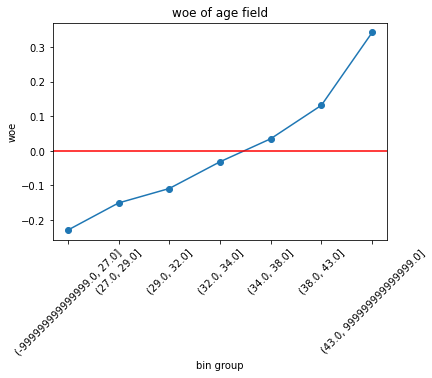

In [ ]:


_plot(df_summary)


In [ ]:

excluded_columns = data_train.columns[13:]
input_columns = [col for col in data_train.columns if col not in excluded_columns]
input_columns.extend(['nhom_no_cic', 'bad_flag'])
X = data[input_columns]
X_train = data_train[input_columns]
X_test = data_test[input_columns]
y_train = data_train['bad_flag']
y_test = data_test['bad_flag']

NameError: name 'data_test' is not defined

In [ ]:
# Đối với các biến numeric
WOE_dict=dict()
nbins = {'contract_limit': 5, 'liab_limit': 5, 'cus_income': 4, 'age':7}
for (col, bins) in nbins.items():
  df_summary, iv, thres = _woe(X, colname=col, n_bins=bins)
  WOE_dict[col] = {'table':df_summary, 'iv':iv}

information value of contract_limit column: 0.18668323055097963
information value of liab_limit column: 0.1876267240364142
information value of cus_income column: 0.0303427631608269
information value of age column: 0.03503287284381351


In [ ]:
object_columns = X_train.select_dtypes(include=['object']).columns.to_list()
for col in object_columns:
  df_summary, IV, thres = _woe(X, colname=col)
  WOE_dict[col] = {'table':df_summary, 'iv':iv}

information value of product_group column: 0.20379175617234252
information value of bi_card_type column: 0.23018011637981406
information value of campaign_group column: 0.5638637286299948
information value of income_tier column: 0.11665093018032549
information value of gender column: 0.12026986978652333
information value of marital_status column: 0.017813546010527592
information value of edu_level column: 0.008124879612424014
information value of province_city column: 0.16190905989151244
information value of cus_class column: 3.3901641591039704
information value of nhom_no_cic column: 0.3043729987262875


In [ ]:
object_columns

[]

# <a id='toc3_'></a>[Xếp hạng các biến theo sức mạnh dự báo](#toc0_)

In [ ]:
columns = []
ivs = []


for col in X_train.columns:
  if col != 'bad_flag':
    columns.append(col)
    ivs.append(WOE_dict[col]['iv'])
df_WOE = pd.DataFrame({'column': columns, 'iv': ivs})

def _rank_iv(iv):
  if iv <= 0.02:
    return 'Useless'
  elif iv <= 0.1:
    return 'Weak'
  elif iv <= 0.3:
    return 'Medium'
  elif iv <= 0.5:
    return 'Strong'
  else:
    return 'suspicious'

df_WOE['rank']=df_WOE['iv'].apply(lambda x: _rank_iv(x))
df_WOE.sort_values('iv', ascending=False)

,column,iv,rank
3,liab_limit,0.187627,Medium
1,contract_limit,0.186683,Medium
0,product_group,0.035033,Weak
2,bi_card_type,0.035033,Weak
4,campaign_group,0.035033,Weak
6,income_tier,0.035033,Weak
7,gender,0.035033,Weak
8,marital_status,0.035033,Weak
9,edu_level,0.035033,Weak
10,province_city,0.035033,Weak


# <a id='toc4_'></a>[Hồi quy logistic](#toc0_)

In [ ]:
WOE_dict.keys()

dict_keys(['contract_limit', 'liab_limit', 'cus_income', 'age', 'product_group', 'bi_card_type', 'campaign_group', 'income_tier', 'gender', 'marital_status', 'edu_level', 'province_city', 'cus_class', 'nhom_no_cic'])

In [ ]:
for col in WOE_dict.keys():
  try:
    key = list(WOE_dict[col]['table']['woe'].index)
    woe = list(WOE_dict[col]['table']['woe'])
    d = dict(zip(key, woe))
    col_woe = col+'_woe'
    X_train[col_woe] = X_train[col].map(d)
  except:
    print(col)


for col in WOE_dict.keys():
  try:
    key = list(WOE_dict[col]['table']['woe'].index)
    woe = list(WOE_dict[col]['table']['woe'])
    d = dict(zip(key, woe))
    col_woe = col+'_woe'
    X_test[col_woe] = X_test[col].map(d)
  except:
    print(col)    

In [ ]:
X_train = X_train.dropna()
X_train = X_train.filter(like='_woe', axis = 1)
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
X_test = X_test.filter(like='_woe', axis = 1)
y_test = y_test.loc[X_test.index]


In [ ]:
X_train

,contract_limit_woe,liab_limit_woe,cus_income_woe,age_woe,product_group_woe,bi_card_type_woe,campaign_group_woe,income_tier_woe,gender_woe,marital_status_woe,edu_level_woe,province_city_woe,cus_class_woe,nhom_no_cic_woe
0,0.283083,0.296682,0.084288,0.043959,-0.597917,0.253044,1.225164,0.174004,0.323024,0.065055,-0.676759,-0.200107,1.885972,-0.742001
1,-0.509231,-0.485759,0.070994,-0.058256,-0.597917,0.371757,-0.470288,0.174004,-0.375950,0.065055,-0.056125,-0.423439,-2.218558,-0.742001
2,0.550260,0.553149,0.137063,0.043959,0.511491,0.204006,0.208607,0.151619,0.323024,0.065055,0.050895,0.333722,-2.956331,0.288174
3,-0.182278,-0.199855,0.137063,-0.116107,-0.761609,0.253044,0.172477,-0.774099,-0.375950,-0.152629,-0.056125,0.050069,1.885972,-0.742001
4,0.283083,0.296682,0.137063,0.043959,-0.597917,-0.706327,-2.233337,0.151619,-0.375950,0.065055,-0.056125,-0.424227,1.885972,-0.742001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187420,0.283083,0.296682,-0.308699,-0.232013,0.057035,0.371757,-0.625953,-0.179015,-0.375950,-0.152629,0.148838,0.050069,-2.218558,0.288174
187421,0.283083,0.296682,-0.308699,-0.169849,0.511491,-0.706327,-0.730611,0.268341,-0.375950,0.065055,-0.676759,-0.002231,-2.218558,0.288174
187422,-0.533396,-0.541662,-0.308699,0.130136,-0.597917,-0.706327,-2.233337,-0.774099,-0.375950,0.065055,-0.297381,0.050069,-2.218558,0.288174
187423,0.283083,0.296682,0.070994,-0.232013,0.057035,-0.706327,0.219541,0.174004,-0.375950,-0.152629,0.050895,0.050069,-2.218558,-0.742001


In [ ]:
from sklearn.linear_model import LogisticRegression

logit_model = LogisticRegression(solver = 'lbfgs', max_iter=1000, fit_intercept=True, tol=0.0001, C=1, penalty='l2')
logit_model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_train = logit_model.predict(X_train)
acc_train = accuracy_score(y_pred_train, y_train)
y_pred_test = logit_model.predict(X_test)
acc_test = accuracy_score(y_pred_test, y_test)

print('accuracy on train: ', acc_train)
print('accuracy on test: ', acc_test)

accuracy on train:  0.9388847917401482
accuracy on test:  0.9381919213507159


# <a id='toc5_'></a>[Trả ra prob of risk cho data](#toc0_)

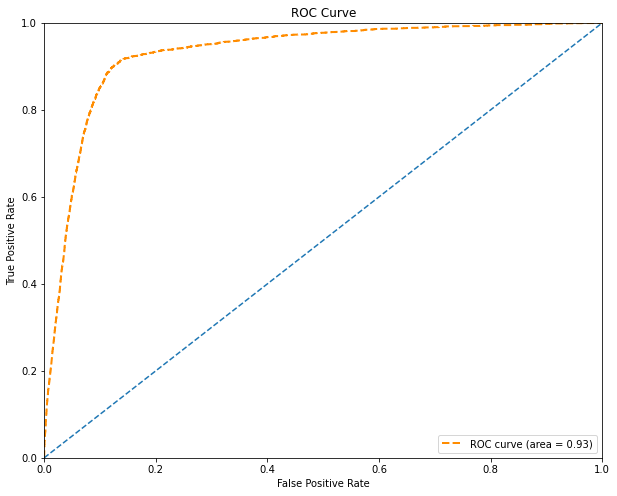

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_prob_test = logit_model.predict_proba(X_test)[:, 1]
fpr, tpr, thres = roc_curve(y_test, y_pred_prob_test)
roc_auc = auc(fpr, tpr)

def _plot_roc_curve(fpr, tpr, thres, auc):
    plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', color='darkorange', lw=2, linestyle='--', label='ROC curve (area = %0.2f)'%auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')

_plot_roc_curve(fpr, tpr, thres, roc_auc)

## <a id='toc5_1_'></a>[Lưu model logistic](#toc0_)

In [ ]:
import joblib
out_put_link = wd + '\\04. model\\logistic_risk_prob.pkl'
# Lưu trữ mô hình bằng joblib
joblib.dump(logit_model, out_put_link)

['d:\\ngamt2\\3. Training\\Py\\hien-main\\04. model\\logistic_risk_prob.pkl']

In [ ]:
y_pred = logit_model.predict_proba(X_test)[:, 1]
data_test.loc[X_test.index, 'prob_of_risk_event'] = y_pred

In [ ]:
data_output_risk = data_test.dropna()

In [ ]:
out_put_link = wd + '\\01. data\\output\\out_put_risk_logistic.csv' 
data_output_risk.to_csv(out_put_link, index=False)

# <a id='toc6_'></a>[Tính điểm score cho mỗi feature](#toc0_)

In [ ]:
import numpy as np

def _CreditScore(beta, alpha, woe, n = 12, odds = 1/4, pdo = -50, thres_score = 600):
  factor = pdo/np.log(2)
  offset = thres_score - factor*np.log(odds)
  score = (beta*woe+alpha/n)*factor+offset/n
  return score

_CreditScore(beta = 0.5, alpha = -1, woe = 0.15, n = 12)

42.2677896003704

In [ ]:
betas_dict = dict(zip(list(X_train.columns), logit_model.coef_[0]))
alpha = logit_model.intercept_[0]
betas_dict

{'contract_limit_woe': 0.7048746340680658,
 'liab_limit_woe': -0.6442256101583405,
 'cus_income_woe': 0.6661108303885332,
 'age_woe': -0.18378701059516978,
 'product_group_woe': 0.18213386239119075,
 'bi_card_type_woe': -0.5303087140414209,
 'campaign_group_woe': 0.4365797861774336,
 'income_tier_woe': 0.6974551227773177,
 'gender_woe': 0.6930481646540595,
 'marital_status_woe': 0.35667815238966594,
 'edu_level_woe': 0.18759026920526597,
 'province_city_woe': 0.4259036362216751,
 'cus_class_woe': 0.9787315385910779,
 'nhom_no_cic_woe': 0.920485657501988}

In [ ]:
cols = []
features = []
woes = []
betas = []
scores = []

for col in columns:
  for feature, woe in WOE_dict[col]['table']['woe'].to_frame().iterrows():
      cols.append(col)
      # Add feature
      feature = str(feature)
      features.append(feature)    
      # Add woe
      woe = woe.values[0]
      woes.append(woe)
      # Add beta
      col_woe = col+'_woe'
      beta = betas_dict[col_woe]
      betas.append(beta)
      # Add score
      score = _CreditScore(beta = beta, alpha = alpha, woe = woe, n = 12)
      scores.append(score)

df_WOE = pd.DataFrame({'Columns': cols, 'Features': features, 'WOE': woes, 'Betas':betas, 'Scores':scores})
df_WOE

,Columns,Features,WOE,Betas,Scores
0,product_group,1. MC2,0.511491,0.182134,51.108412
1,product_group,2. Titanium,-0.597917,0.182134,65.684012
2,product_group,3. Platinum,0.057035,0.182134,57.079136
3,product_group,4. World,-0.761609,0.182134,67.834631
4,product_group,5. Visa Platinum,-0.199469,0.182134,60.449130
...,...,...,...,...,...
231,nhom_no_cic,1,0.288174,0.920486,38.693980
232,nhom_no_cic,2,2.232458,0.920486,-90.404502
233,nhom_no_cic,3,2.480410,0.920486,-106.868300
234,nhom_no_cic,4,2.438177,0.920486,-104.064087


In [ ]:
def _search_score(obs, col):
  feature = [str(inter) for inter in list(WOE_dict[col]['table'].index) if obs[col].values[0] in inter][0]
  score = df_WOE[(df_WOE['Columns'] == col) & (df_WOE['Features'] == feature)]['Scores'].values[0]
  return score

In [ ]:
test_obs = data_test[columns].iloc[0:1, :]
test_obs

,product_group,contract_limit,bi_card_type,liab_limit,campaign_group,cus_income,income_tier,gender,marital_status,edu_level,province_city,age,cus_class,nhom_no_cic
146091,4. World,-75000000.0,ONLINE CARD,-75000000.0,CASA,30000000.0,4.15M-40M,FEMALE,Married,Junior college,Ha Noi,37,PRIORITY,1


In [ ]:
scores = dict()


for col in columns:
    scores[col] = _search_score(test_obs, col)
total_score = sum(scores.values())

scores, total_score

({'product_group': 67.83463060804755,
  'contract_limit': 84.94947613164425,
  'bi_card_type': 30.808847070086983,
  'liab_limit': 32.65686367743359,
  'campaign_group': 80.83728704641604,
  'cus_income': 53.77847480071861,
  'income_tier': 49.0741773447656,
  'gender': 76.62329188163822,
  'marital_status': 56.15467072860694,
  'edu_level': 57.13976425805823,
  'province_city': 70.83754886243796,
  'age': 58.4112484879586,
  'cus_class': 266.5470691003928,
  'nhom_no_cic': 38.69398017352127},
 1024.3473301717268)

In [ ]:
def _total_score(obs, columns = columns):
  scores = dict()
  for col in columns:
    scores[col] = _search_score(obs, col)
  total_score = sum(scores.values())
  return scores, total_score

scores, total_score = _total_score(test_obs)
# print('score for each fields: \n', scores)
# print('final total score: ', total_score)


In [ ]:

total_scores = []


for i in np.arange(data_output_risk[columns].shape[0]):
  obs = data_output_risk[columns].iloc[i:(i+1), :]
  _, score = _total_score(obs)
  total_scores.append(score)
data_output_risk['Score'] = total_scores

In [ ]:
out_put_link = wd + '\\01. data\\output\\out_put_scorecard.csv' 
data_output_risk.to_csv(out_put_link, index=False)

### Prob Risk Predicted Plot

In [ ]:
out_put_link = wd + '\\01. data\\output\\out_put_scorecard.csv' 
data_test = pd.read_csv(out_put_link)

In [ ]:
data_test.columns

Index(['product_group', 'contract_limit', 'bi_card_type', 'liab_limit',
       'campaign_group', 'cus_income', 'income_tier', 'gender',
       'marital_status', 'edu_level', 'province_city', 'age', 'cus_class',
       'ovd_days', 'ovd_days_6m', 'ovd_days_12m', 'ovd_days_24m',
       'ovd_days_36m', 'nhom_no_cic', 'revolver_group', 'nii_24m', 'nfi_24m',
       'toi_24m', 'provision_24m', 'bad_flag'],
      dtype='object')

Text(0.5, 1.0, 'Distribution Score in Default vs Non-Default')

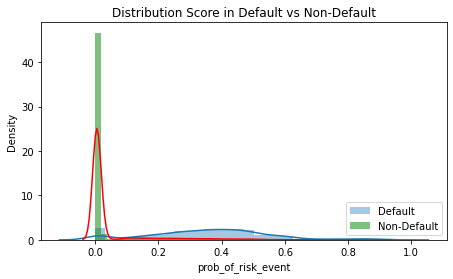

In [ ]:
plt.figure(figsize=(16, 4))
# plt.subplot(121)
# sns.distplot(data['Score'])
# plt.title('Distribution Score of Total data')
plt.subplot(122)
sns.distplot(data_test[data_test['bad_flag']==1]['prob_of_risk_event'], label='Default')
sns.distplot(data_test[data_test['bad_flag']==0]['prob_of_risk_event'], label='Non-Default', 
             kde_kws={"color": "r"}, 
             hist_kws={"color": "g", "alpha":0.5})
plt.legend(loc = 'lower right')
plt.title('Distribution Score in Default vs Non-Default')

Text(0.5, 1.0, 'Distribution Score in Default vs Non-Default')

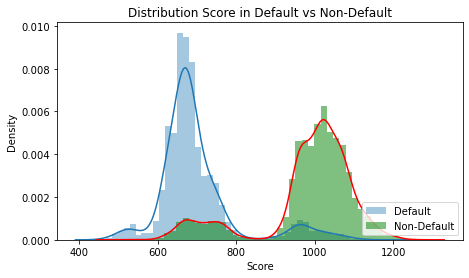

In [ ]:
plt.figure(figsize=(16, 4))
# plt.subplot(121)
# sns.distplot(data['Score'])
# plt.title('Distribution Score of Total data')
plt.subplot(122)
sns.distplot(data_test[data_test['bad_flag']==1]['Score'], label='Default')
sns.distplot(data_test[data_test['bad_flag']==0]['Score'], label='Non-Default', 
             kde_kws={"color": "r"}, 
             hist_kws={"color": "g", "alpha":0.5})
plt.legend(loc = 'lower right')
plt.title('Distribution Score in Default vs Non-Default')